---
title: "City Detector 🏙️"
author: "Jaekang Lee"
date: "2020-10-27"
categories: [computer_vision, classification]
---

# City Detector 🏙️
> Coquitlam Paris Seoul and New York. 


## Let's make app that recognizes Coquitlam!

In [1]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [2]:
#hide
import os
key = os.environ.get('AZURE_SEARCH_KEY', '39f25aae8d744a528b964a94a4af8b58')

## Let's get the images of each city

In [3]:
city_types = 'seoul city','coquitlam','paris city', 'new york city'
path = Path('cities')

In [4]:
if not path.exists():
    path.mkdir()
    for o in city_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('content_url'))

In [5]:
#hide_output
fns = get_image_files(path)
fns

(#596) [Path('cities/coquitlam/00000000.jpg'),Path('cities/coquitlam/00000001.jpg'),Path('cities/coquitlam/00000002.png'),Path('cities/coquitlam/00000003.jpg'),Path('cities/coquitlam/00000004.jpg'),Path('cities/coquitlam/00000005.jpg'),Path('cities/coquitlam/00000006.jpg'),Path('cities/coquitlam/00000007.jpg'),Path('cities/coquitlam/00000008.jpg'),Path('cities/coquitlam/00000009.jpg')...]

In [6]:
#hide_output
failed = verify_images(fns)
failed

(#16) [Path('cities/coquitlam/00000067.jpg'),Path('cities/coquitlam/00000077.JPG'),Path('cities/coquitlam/00000079.jpg'),Path('cities/coquitlam/00000135.jpg'),Path('cities/new york city/00000010.jpg'),Path('cities/new york city/00000014.jpg'),Path('cities/new york city/00000020.jpg'),Path('cities/new york city/00000026.jpg'),Path('cities/new york city/00000029.jpg'),Path('cities/new york city/00000037.jpg')...]

In [7]:
failed.map(Path.unlink)

(#16) [None,None,None,None,None,None,None,None,None,None...]

## Let's load the data

In [8]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i, self: self[i])

In [9]:
cities = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

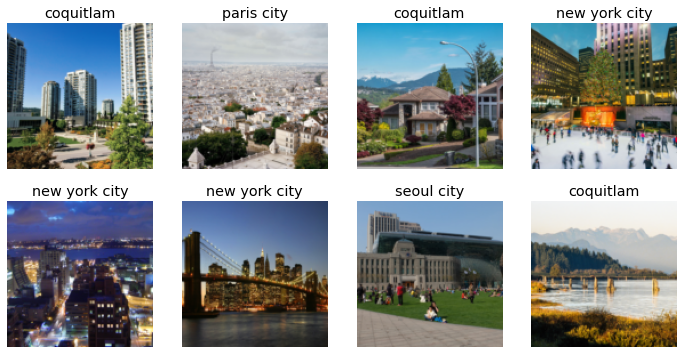

In [10]:
dls = cities.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows = 2)

## Let's scale and augment the datas

In [11]:
cities = cities.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                        batch_tfms=aug_transforms())
dls = cities.dataloaders(path, num_workers=0) # <- num_workers=0 to prevent window error

## Let's build and run a CNN model

In [12]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.187395,1.315027,0.482759,00:42


epoch,train_loss,valid_loss,error_rate,time
0,1.307873,0.871226,0.336207,00:41
1,1.064780,0.831430,0.241379,00:41
2,0.876646,0.767134,0.215517,00:41
3,0.784991,0.738216,0.224138,00:49


## Let's look at the confusion matrix

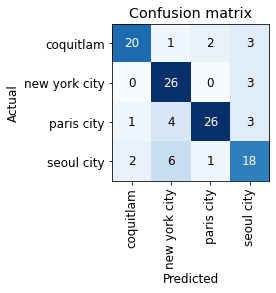

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We got an accuracy of 26/90 = 71% (rounded)

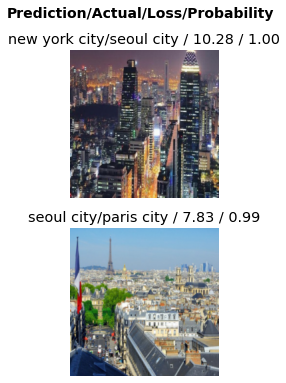

In [16]:
interp.plot_top_losses(2,nrows=2)

## Let's try to clean up the dataset

In [17]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [18]:
# Deleted Photos of maps, inside of home and image of just texts
for idx in cleaner.delete(): cleaner.fns[idx].unlink() # delete 

In [23]:
dls = cities.dataloaders(path, num_workers=0)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.933403,1.322945,0.460870,00:38


epoch,train_loss,valid_loss,error_rate,time
0,1.258363,0.800413,0.347826,00:37
1,1.014135,0.660854,0.243478,00:38
2,0.851025,0.609896,0.243478,00:38
3,0.725140,0.591347,0.217391,00:37
4,0.623130,0.582418,0.226087,00:37


Valid_loss doesn't decrease so we stop

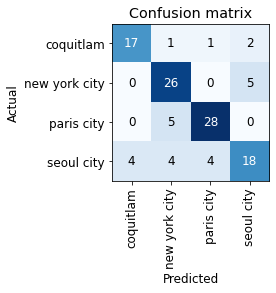

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

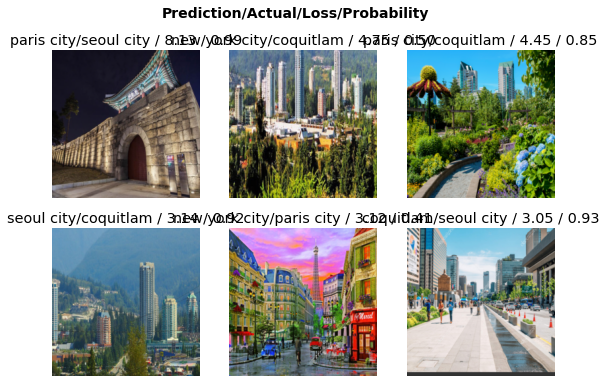

In [26]:
interp.plot_top_losses(6,nrows=2)

It looks like it has a hard time highlighting seoul city's characteristics as most error comes from seoul images. Suspected factors include seoul having new york like buildings, mountains like coquitlam and brick structures like paris city.

## Ignore Below (Deployment IPR)

In [27]:
learn.export()

In [28]:
#hide_output
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [29]:
learn_inf = load_learner(path/'export.pkl')

In [31]:
learn_inf.dls.vocab

['coquitlam', 'new york city', 'paris city', 'seoul city']

In [33]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [35]:
img = PILImage.create(btn_upload.data[-1])

In [36]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [38]:
pred,pred_idx,probs = learn_inf.predict(img)
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: paris city; Probability: 1.0000')

## Classify Button & Event Handler

In [39]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [40]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [41]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])